# Evidencia Portafolio

Momento de Retroalimentación: Módulo 2 Implementación de un modelo de deep learning. (Portafolio Implementación)

Por: Alan Contreras Prieto - A01749667

In [135]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
#pip install 

In [137]:
#import funcionesIA as f_IA
from funcionesIA import *
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, LayerNormalization, Concatenate, Bidirectional, Attention
from tensorflow.keras.layers import Conv1D, BatchNormalization

# Introducción: 

En el sector energético moderno, la estabilidad y eficiencia de la red eléctrica dependen fundamentalmente del correcto funcionamiento de sus componentes críticos, siendo los transformadores eléctricos uno de los activos más vitales. El problema central que aborda este proyecto es la predicción de series de tiempo multivariadas para estimar el comportamiento futuro de un transformador eléctrico. Específicamente, se busca predecir la Temperatura del Aceite (OT - Oil Temperature) basándose en datos históricos de carga eléctrica y temperatura. Los transformadores generan calor durante su operación; si este calor no se disipa correctamente o excede los límites operativos, puede provocar fallos catastróficos, interrupciones del servicio y daños irreversibles al equipo.

**Relevancia**: La capacidad de predecir la temperatura del transformador con antelación tiene un impacto directo en la implementación de estrategias de mantenimiento predictivo.

* Seguridad: Previene explosiones o incendios causados por sobrecalentamiento.

* Eficiencia Económica: Reduce los costos asociados con el mantenimiento correctivo de emergencia y prolonga la vida útil de activos costosos.

* Estabilidad de la Red: Permite a los operadores gestionar mejor las cargas en horas pico, sabiendo de antemano si un transformador está en riesgo de saturación térmica.

# Datos: 


### Descripción del Dataset y fuente:

Para este proyecto se utiliza el Electricity Transformer Dataset (ETDataset), un conjunto de datos público recolectado de transformadores eléctricos reales en China.

En la carpeta data se encuentran 2 versiones de diferentes transformadores, una con registros cada 15 minutos y otra con registros cada hora.

Contenido: El dataset contiene registros históricos de dos años.

Variables: Cada registro incluye su fecha de registro y 7 variables númericas:

* date: fecha de registro

* HUFL: High Use Full Load (Carga completa de uso alto).

* HULL: High Use Less Load (Menos carga de uso alto).

* MUFL: Medium Use Full Load.

* MULL: Medium Use Less Load.

* LUFL: Low Use Full Load.

* LULL: Low Use Less Load.

* OT: Oil Temperature (Temperatura del aceite) - Variable Objetivo.

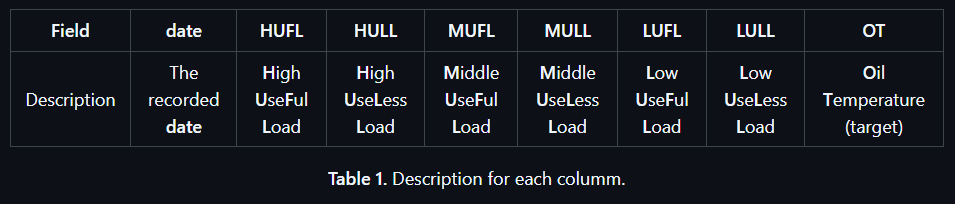

Repositorio GitHub de Zhouhaoyi - ETDataset 

Link: https://github.com/zhouhaoyi/ETDataset/

```bibtex
@inproceedings{haoyietal-informer-2021,
  author    = {Haoyi Zhou and
               Shanghang Zhang and
               Jieqi Peng and
               Shuai Zhang and
               Jianxin Li and
               Hui Xiong and
               Wancai Zhang},
  title     = {Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting},
  booktitle = {The Thirty-Fifth {AAAI} Conference on Artificial Intelligence, {AAAI} 2021, Virtual Conference},
  volume    = {35},
  number    = {12},
  pages     = {11106--11115},
  publisher = {{AAAI} Press},
  year      = {2021},
}

## Carga de datos

In [138]:
datamin = False
if datamin:
    data = pd.read_csv("data/ETTm2.csv") #Version con registros cada 15 min
else:
    data = pd.read_csv("data/ETTh2.csv") #Version con registros cada hora
#
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 00:00:00,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
2016-07-01 01:00:00,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001
2016-07-01 02:00:00,37.946999,11.309,35.330002,9.007,2.100,0.000,36.465000
2016-07-01 03:00:00,38.952000,11.895,35.543999,9.436,3.380,1.215,33.608501
2016-07-01 04:00:00,38.113998,11.476,35.410000,9.623,2.036,0.000,31.850500
...,...,...,...,...,...,...,...
2018-06-26 15:00:00,39.202999,11.392,49.644001,11.929,-10.331,-1.258,47.084999
2018-06-26 16:00:00,38.113998,10.974,48.759998,11.366,-10.331,-1.290,48.183498
2018-06-26 17:00:00,39.622002,10.974,50.609001,11.661,-11.557,-1.418,48.183498


## Análisis

Matriz de correlación

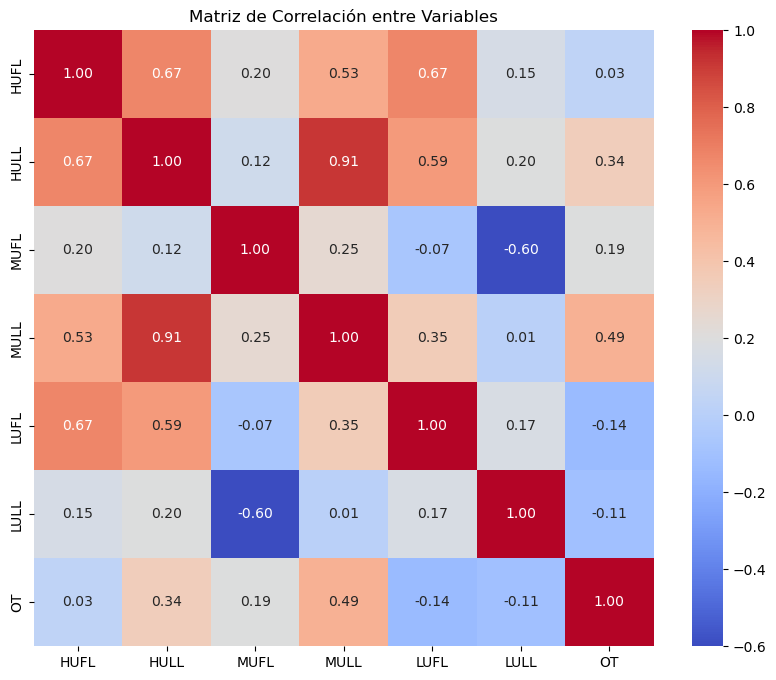

In [139]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación entre Variables')
plt.show()

Información de tipos de datos y nulos

In [140]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17420 entries, 2016-07-01 00:00:00 to 2018-06-26 19:00:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HUFL    17420 non-null  float64
 1   HULL    17420 non-null  float64
 2   MUFL    17420 non-null  float64
 3   MULL    17420 non-null  float64
 4   LUFL    17420 non-null  float64
 5   LULL    17420 non-null  float64
 6   OT      17420 non-null  float64
dtypes: float64(7)
memory usage: 1.1 MB


Estadísticas descriptivas:

In [141]:
data.describe()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
count,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000
mean,37.193346,8.537565,43.830356,8.322694,-3.423605,-2.085969,26.609376
std,10.218855,6.020442,13.056798,4.366059,6.144403,6.012796,11.888266
min,0.000000,-18.680000,11.205000,-6.594000,-14.350000,-31.462000,-2.646500
25%,30.156000,4.523000,37.394001,5.683000,-9.254000,-2.505000,16.469500
50%,37.193001,9.131000,41.388000,9.302000,-3.774000,-1.226000,26.577000
75%,44.062000,13.152000,46.078999,11.258000,2.527000,0.000000,35.585999
max,107.892998,36.438999,93.230003,28.736000,17.218000,2.932000,58.876999


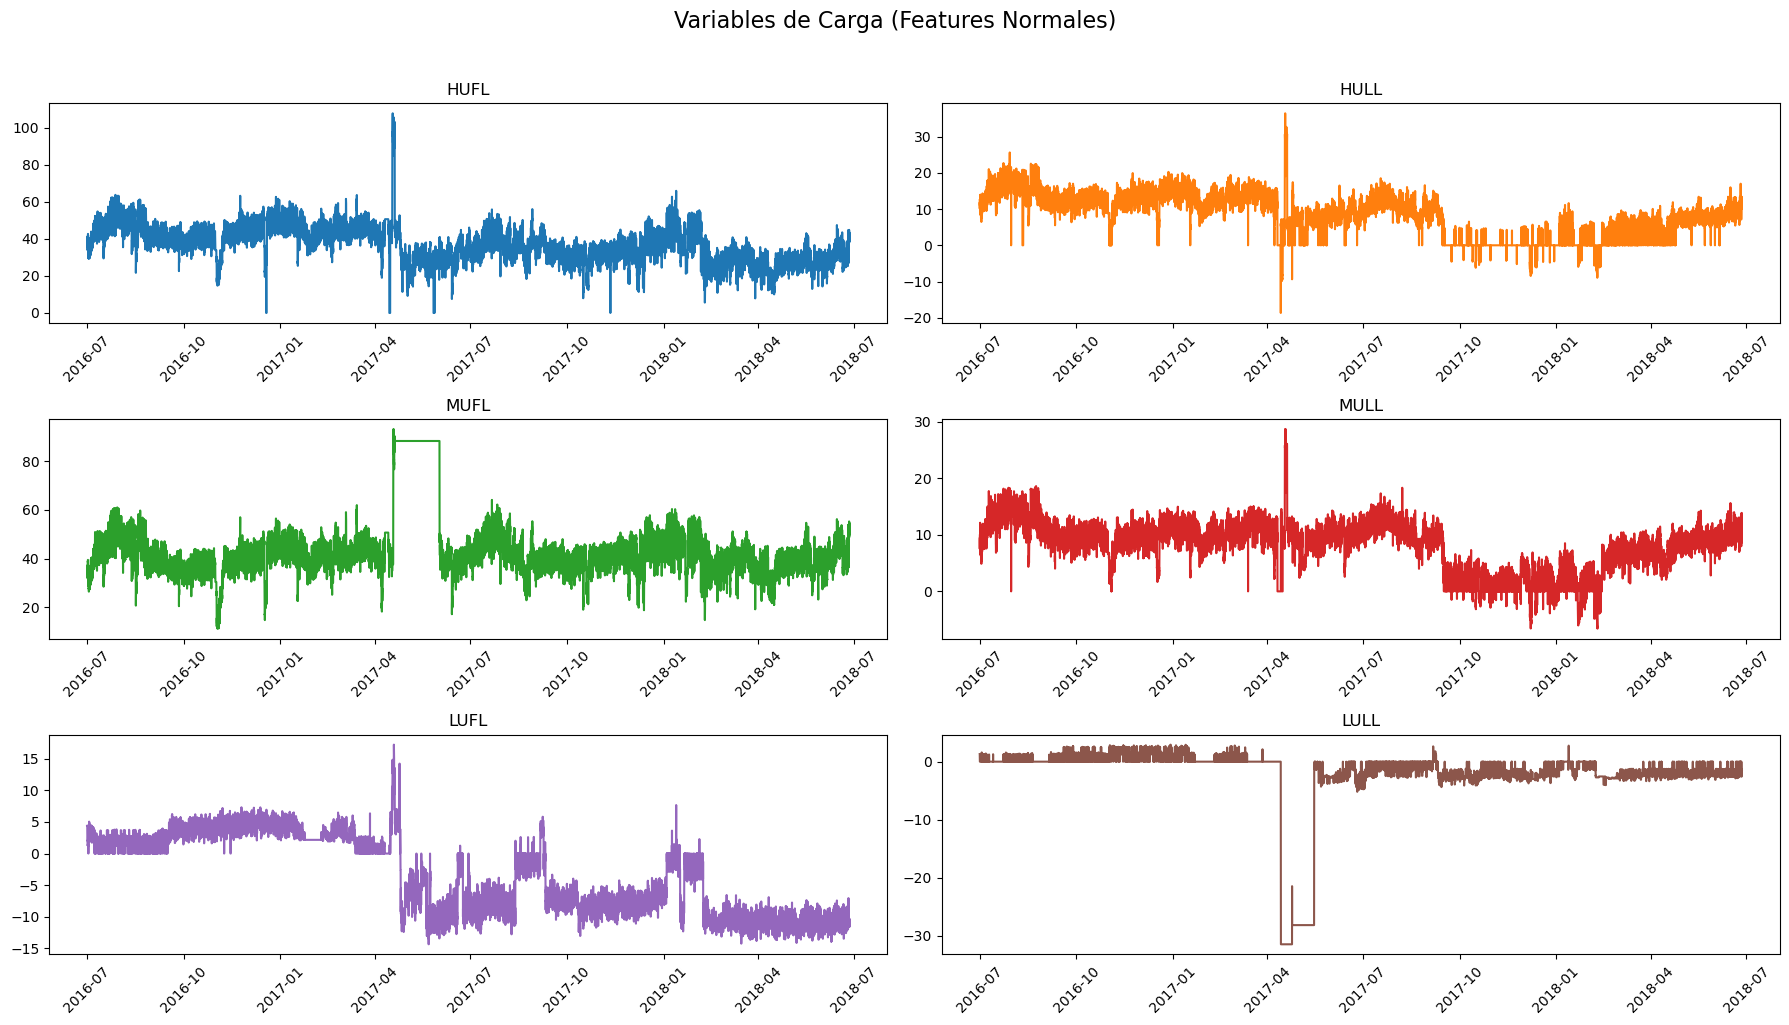

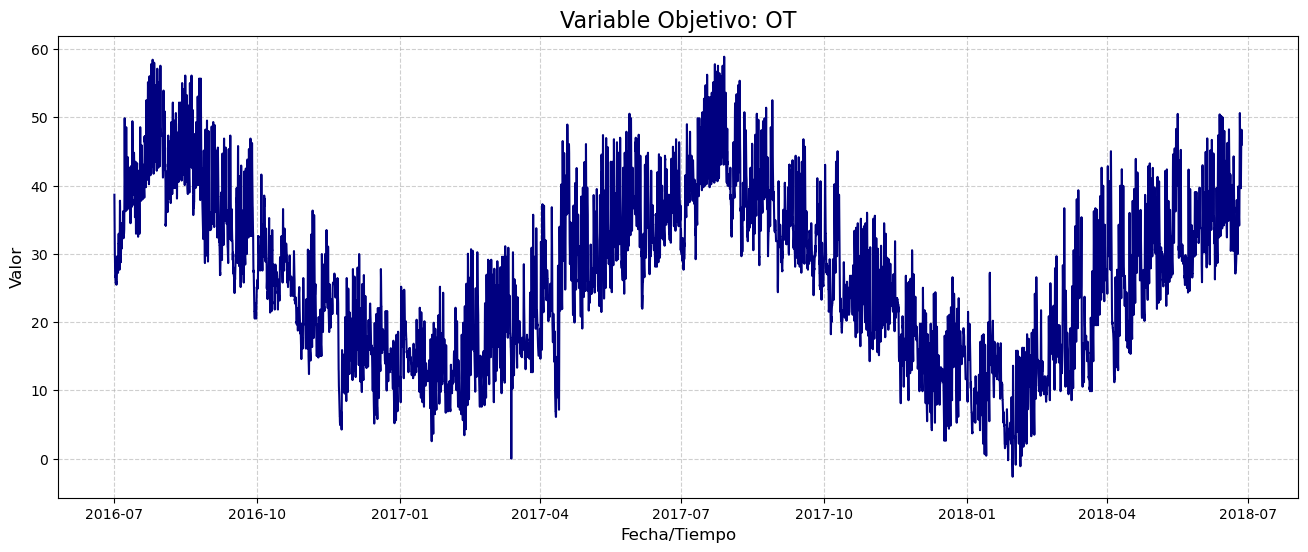

In [142]:
feature_cols = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']
target_col   = 'OT'
plot_time_series(data, feature_cols, target_col)

## Separación en entrenamiento y prueba

In [143]:
# Agrega características de tiempo al DataFrame basado en el índice de fecha/hora.
data = add_time_features(data,datamin)

In [144]:
X = data.drop(columns=[target_col])
y = data[target_col]
X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, y, test_size=0.25, valid_size=0.4)
X_train.shape, X_valid.shape, X_test.shape

((13065, 16), (2613, 16), (1742, 16))

## Preprocesamiento

## Escalado

In [145]:
res = scale_data(X_train, X_valid, X_test, y_train, y_valid, y_test)
X_train_s, X_valid_s, X_test_s, y_train_s, y_valid_s, y_test_s, x_scaler, y_scaler = res

## Sequencias

In [146]:
if datamin:
    SEQUENCE_LENGTH = 96 # 1 Full day = 24 hours * 4 (15 min intervals)
    #SEQUENCE_LENGTH = SEQUENCE_LENGTH * 7 # 1 Full week
else:
    SEQUENCE_LENGTH = 24 # 1 Full day = 24 hours  
    #SEQUENCE_LENGTH = SEQUENCE_LENGTH * 7 # 1 Full week
X_train_seq, y_train_seq = create_sequences(X_train_s, y_train_s, SEQUENCE_LENGTH)
X_valid_seq, y_valid_seq = create_sequences(X_valid_s, y_valid_s, SEQUENCE_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_s, y_test_s, SEQUENCE_LENGTH)
X_train_seq.shape, y_train_seq.shape, X_valid_seq.shape, y_valid_seq.shape, X_test_seq.shape, y_test_seq.shape

N_FEATURES = X_train_seq.shape[2]  # Número total de features (cargas + temporales)

# Desarrollo del modelo: 
Descripción de la arquitectura empleada, entrenamiento y evaluación de resultados.


### Cambios en la arquitectura

La primera versión del modelo fue deliberadamente sencilla y tenía como propósito únicamente verificar el flujo de entrenamiento. Su arquitectura fue mínima:

* Una sola capa LSTM con pocas unidades

* Una capa densa final para producir la salida

* Arquitectura construida rápidamente con Sequential

Este modelo funcionó como "baseline de prueba", pero no tenía capacidad suficiente para capturar patrones temporales relevantes. La pérdida de entrenamiento disminuía ligeramente, pero el error de validación permanecía estable, indicando que el modelo no estaba aprendiendo de la secuencia.

Mejora de arquitectura

- En una iteración posterior se incorporó una capa bidireccional en la primera etapa del encoder (usando Bidirectional(LSTM(128, ...))) seguida de normalización, una segunda LSTM, un bloque de self-attention y una LSTM final para condensar la secuencia; la idea fue que la bidireccionalidad permita al modelo aprender patrones tanto hacia adelante como hacia atrás en la ventana temporal —lo cual es útil cuando la señal contiene dependencias que se benefician de contexto pasado y futuro dentro de la ventana—, mientras que LayerNormalization, kernel_regularizer y dropout controlan el mayor número de parámetros que introduce la capa bidireccional; la atención se añadió para focalizar las partes más relevantes de la secuencia y se concatena con la salida recurrente para preservar información original + ponderada, logrando así una arquitectura más expresiva que captura relaciones temporales complejas sin depender únicamente de la memoria secuencial de las LSTM.

Cambio de función de perdida:

- También se modificó la función de pérdida, pasando de MAE a Huber Loss, ya que esta última es más robusta frente a outliers y suaviza el impacto de errores muy grandes, lo cual suele beneficiar a modelos de series de tiempo con ruido o variaciones abruptas. 

- Sin embargo, el cambio no produjo mejoras significativas, por lo que se diseñó una función de pérdida personalizada enfocada en penalizar con mayor fuerza los errores cometidos en los picos o valores altos de la serie. Esta custom_loss combina un término MSE estándar con un término adicional que detecta automáticamente valores por encima de la media + desviación estándar y multiplica su error por un factor mayor, obligando al modelo a aprender mejor los comportamientos extremos que antes ignoraba. Esta modificación buscó corregir el sesgo del modelo hacia valores medios y mejorar su capacidad para seguir eventos de alta relevancia en la dinámica temporal.

Cambio de secuencias
- Se evaluó el efecto de aumentar la longitud de la secuencia por ejemplo, de 96 pasos (un día) a 672 (una semana). Esto causó un incremento drástico del tiempo por época, mayor dificultad para que la LSTM convergiera y riesgo de sobreajuste por secuencias demasiado largas. Por lo que se descartó y limitó a aumentar la secuencia a un par de días como máximo.

## Construcción del Modelo

In [147]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, LayerNormalization, Concatenate, Bidirectional, Attention

def build_lstm_model(seq_len, n_feat):
    # 1. Capa de entrada
    inputs = Input(shape=(seq_len, n_feat))

    # 2. Primera LSTM (opcionalmente bidireccional)
    x = Bidirectional(LSTM(128,return_sequences=True,dropout=0.1,recurrent_dropout=0.1,kernel_regularizer="l2"))(inputs)

    x = LayerNormalization()(x)

    # 3. Segunda LSTM
    x2 = LSTM(64,return_sequences=True,dropout=0.1,recurrent_dropout=0.1,kernel_regularizer="l2")(x)

    x2 = LayerNormalization()(x2)

    # 4. Bloque de Atención
    attention_output = Attention()([x2, x2])  # self-attention

    # Concateno para conservar información original + atención
    x3 = Concatenate()([x2, attention_output])

    # 5. Última LSTM para condensar la secuencia
    x4 = LSTM(32,return_sequences=False,dropout=0.1,recurrent_dropout=0.1,kernel_regularizer="l2")(x3)

    # 6. Dropout de regularización
    x4 = Dropout(0.2)(x4)

    # 7. Capa densa final (regresión)
    outputs = Dense(1)(x4)

    model = Model(inputs, outputs)
    return model

def custom_loss(y_true, y_pred):
    # MSE básico
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    
    # Penalización extra para valores altos (picos)
    high_value_mask = tf.cast(y_true > tf.reduce_mean(y_true) + tf.math.reduce_std(y_true), tf.float32)
    high_value_penalty = tf.reduce_mean(high_value_mask * tf.square(y_true - y_pred)) * 2.0
    
    return mse + high_value_penalty
"""# Construcción y compilación del modelo
lstm_model = build_lstm_model(SEQUENCE_LENGTH, N_FEATURES)

optimizer = Adam(learning_rate=0.0015)

lstm_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.Huber(),
    metrics=["mae"]
    #loss='mean_squared_error', # Para regresión
    #metrics=['mean_absolute_error'] # Métrica más interpretable
)

lstm_model.summary()"""

'# Construcción y compilación del modelo\nlstm_model = build_lstm_model(SEQUENCE_LENGTH, N_FEATURES)\n\noptimizer = Adam(learning_rate=0.0015)\n\nlstm_model.compile(\n    optimizer=optimizer,\n    loss=tf.keras.losses.Huber(),\n    metrics=["mae"]\n    #loss=\'mean_squared_error\', # Para regresión\n    #metrics=[\'mean_absolute_error\'] # Métrica más interpretable\n)\n\nlstm_model.summary()'

In [148]:
# Construcción y compilación del modelo
lstm_model = build_lstm_model(SEQUENCE_LENGTH, N_FEATURES)

optimizer = Adam(learning_rate=0.0015)

lstm_model.compile(
    optimizer=optimizer,
    loss=custom_loss,
    metrics=["mae"]
)
lstm_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 24, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_8     │ (None, 24, 256)   │    148,480 │ input_layer_9[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 256)   │        512 │ bidirectional_8[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_25 (LSTM)      │ (None, 24, 64)    │     82,176 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 64)    │        128 │ lstm_25[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_8         │ (None, 24, 64)    │          0 │ layer_normalizat… │
│ (Attention)         │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 24, 128)   │          0 │ layer_normalizat… │
│ (Concatenate)       │                   │            │ attention_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_26 (LSTM)      │ (None, 32)        │     20,608 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 32)        │          0 │ lstm_26[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1)         │         33 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 251,937 (984.13 KB)

 Trainable params: 251,937 (984.13 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento

In [149]:
# Early Stopping para detener el entrenamiento si la pérdida de validación deja de mejorar para evitar overfitting
early_stop = EarlyStopping(
    monitor='val_loss',         # Monitorea la pérdida de validación
    patience=5,                # Número de épocas sin mejora antes de detener
    restore_best_weights=True   # Mantiene los mejores pesos encontrados
)

history = lstm_model.fit(
    X_train_seq, 
    y_train_seq, 
    epochs=100,                 # Un número alto, ya que Early Stopping lo detendrá
    batch_size=32,
    validation_data=(X_valid_seq, y_valid_seq),
    callbacks=[early_stop] 
)

Epoch 1/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 39s 66ms/step - loss: 1.0533 - mae: 0.1199 - val_loss: 0.1570 - val_mae: 0.1217
Epoch 2/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - loss: 0.0740 - mae: 0.0948 - val_loss: 0.0421 - val_mae: 0.1094
Epoch 3/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - loss: 0.0301 - mae: 0.0923 - val_loss: 0.0339 - val_mae: 0.1167
Epoch 4/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - loss: 0.0457 - mae: 0.0954 - val_loss: 0.0323 - val_mae: 0.1017
Epoch 5/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - loss: 0.0216 - mae: 0.0898 - val_loss: 0.0273 - val_mae: 0.1036
Epoch 6/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - loss: 0.0185 - mae: 0.0845 - val_loss: 0.0316 - val_mae: 0.1003
Epoch 7/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - loss: 0.0186 - mae: 0.0850 - val_loss: 0.0294 - val_mae: 0.1099
Epoch 8/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - loss: 0.0184 - mae: 0.0844 - val_loss: 0.0234 - val_mae: 0.0981
Epoch 9/100
408/408 ━━━━━━━━━━━━

## Evaluación:

Evaluando el modelo en el conjunto de prueba...

--- Resultados de la Prueba ---
Pérdida (MSE) en Test (escalado): 0.016486
Error Absoluto Medio (MAE) en Test (escalado): 0.079701
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step


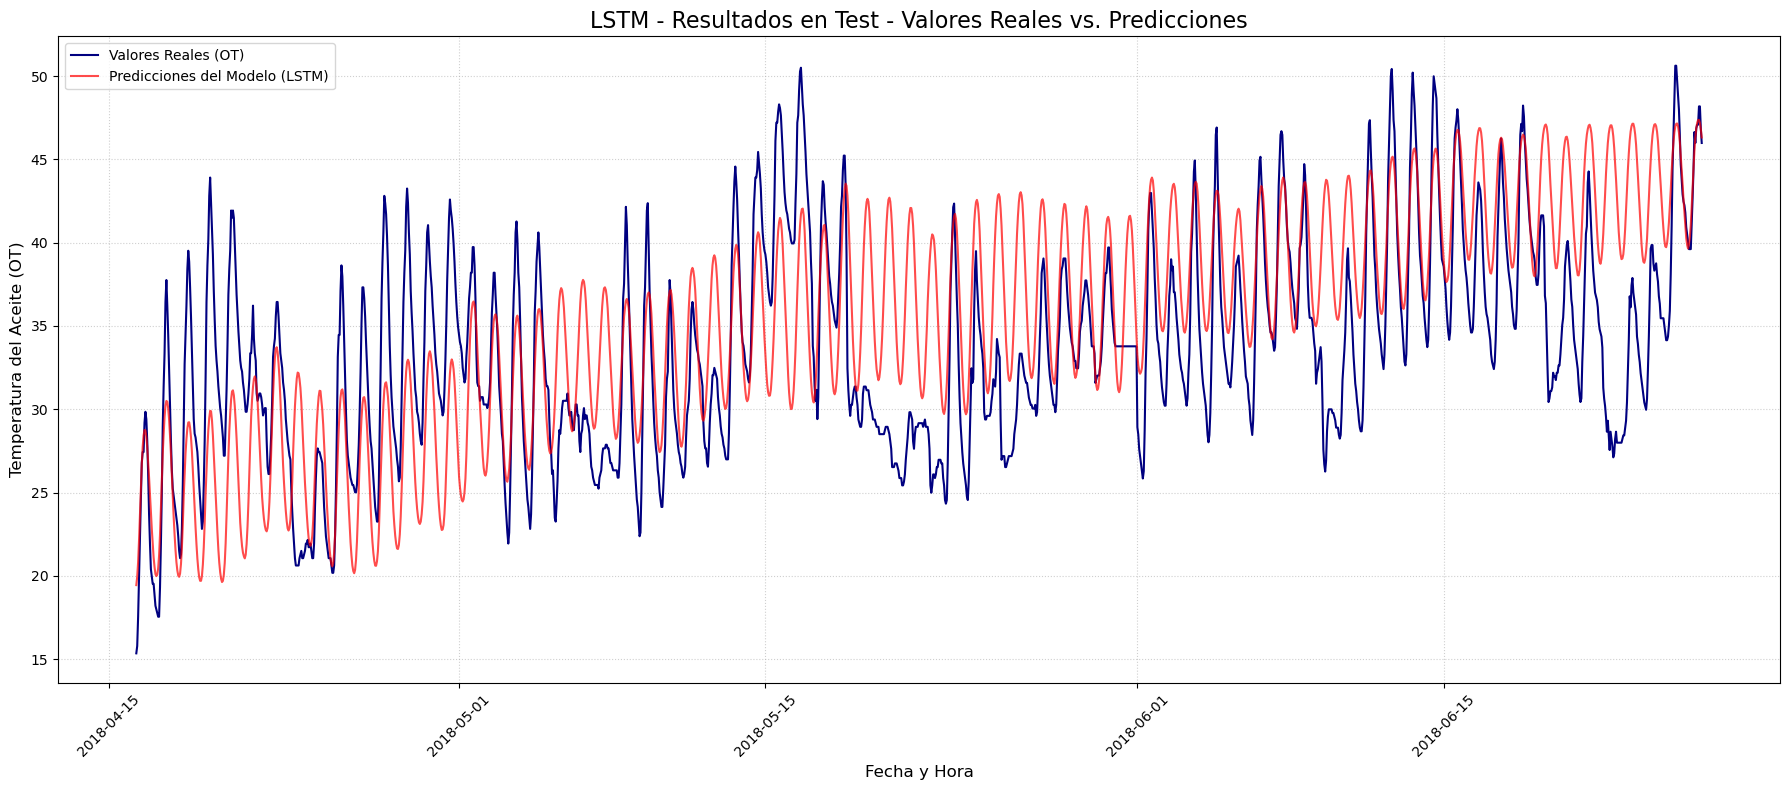

MAE en la escala Real: 4.69


In [150]:
print("Evaluando el modelo en el conjunto de prueba...")
test_loss, test_mae = lstm_model.evaluate(X_test_seq, y_test_seq, verbose=0)

print(f"\n--- Resultados de la Prueba ---")
# El error está en la escala escalada (0 a 1)
print(f"Pérdida (MSE) en Test (escalado): {test_loss:.6f}")
print(f"Error Absoluto Medio (MAE) en Test (escalado): {test_mae:.6f}")


# 1. Generar Predicciones (Aún en la escala de 0 a 1)
y_pred_scaled = lstm_model.predict(X_test_seq).flatten()

# 2. Desescalar 
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = y_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

plot_predictions(y_true, y_pred, data.index[-len(y_true):], title_prefix="LSTM - Resultados en Test")
mae_validacion = mean_absolute_error(y_true, y_pred)
print(f"MAE en la escala Real: {mae_validacion:.2f}")

# Ajuste del modelo: 
Ajuste de hiperparámetros/cambios en arquitectura para mejorar resultados previos (al menos una iteración).

# Resultados: 
Evaluación de modelo final con datos de prueba.


In [151]:
print("Evaluando el modelo en el conjunto de prueba...")
test_loss, test_mae = lstm_model.evaluate(X_test_seq, y_test_seq, verbose=0)

print(f"\n--- Resultados de la Prueba ---")
# El error está en la escala escalada (0 a 1)
print(f"Pérdida (MSE) en Test (escalado): {test_loss:.6f}")
print(f"Error Absoluto Medio (MAE) en Test (escalado): {test_mae:.6f}")

Evaluando el modelo en el conjunto de prueba...

--- Resultados de la Prueba ---
Pérdida (MSE) en Test (escalado): 0.016486
Error Absoluto Medio (MAE) en Test (escalado): 0.079701


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


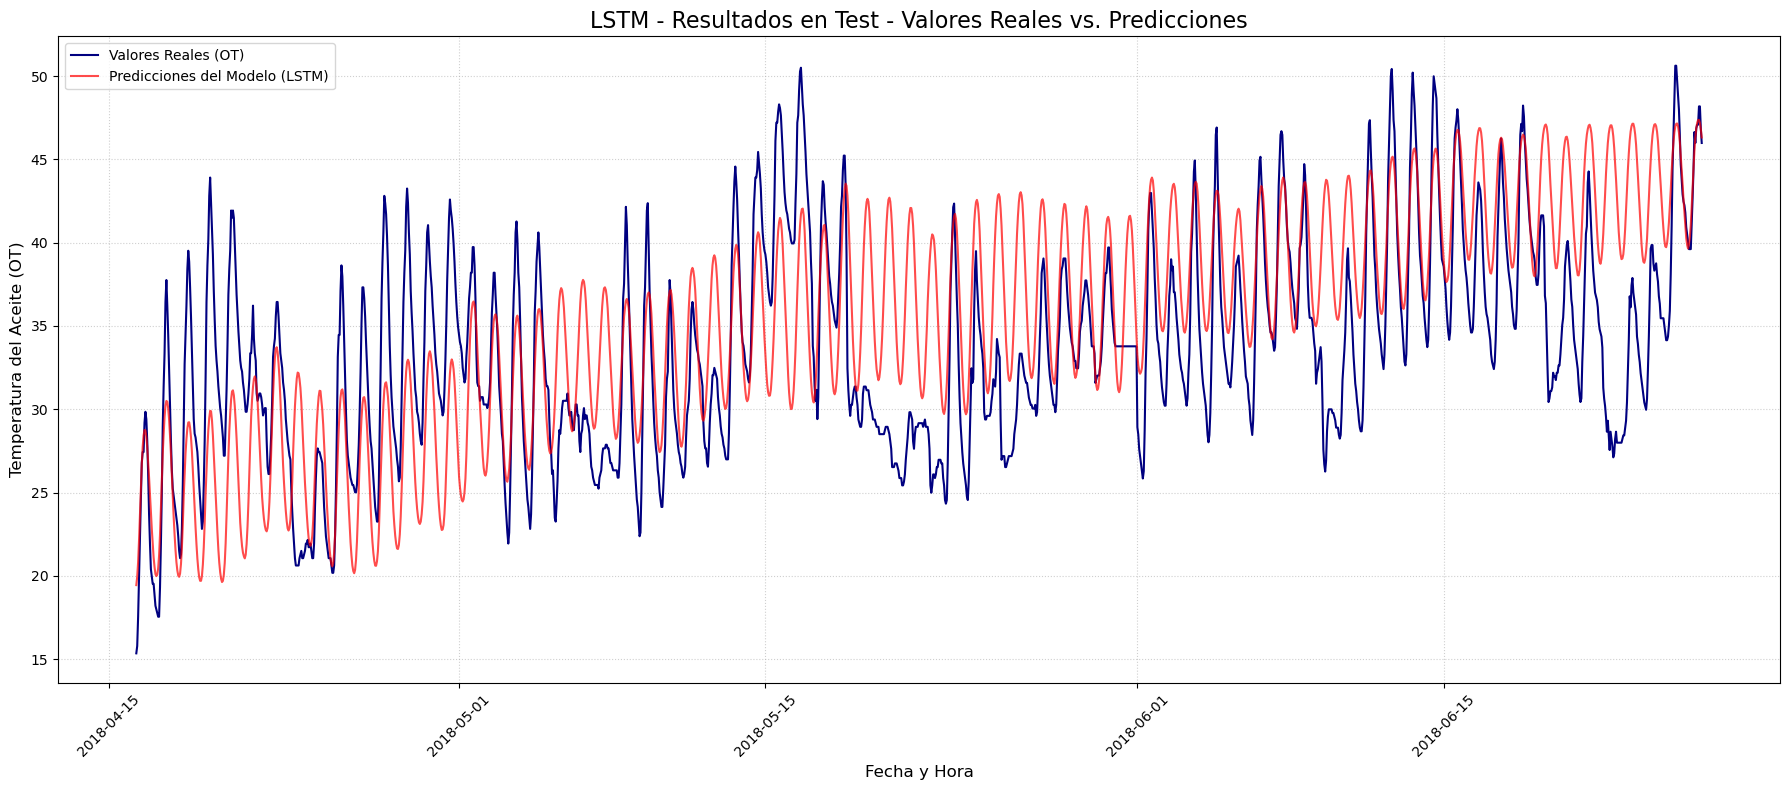

MAE validación en la escala Real: 4.69
MAE FINAL en la escala Real: 4.69


In [152]:
# 1. Generar Predicciones (Aún en la escala de 0 a 1)
y_pred_scaled = lstm_model.predict(X_test_seq).flatten()

# 2. Desescalar 
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = y_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()
plot_predictions(y_true, y_pred, data.index[-len(y_true):], title_prefix="LSTM - Resultados en Test")
mae_real = mean_absolute_error(y_true, y_pred)
print(f"MAE validación en la escala Real: {mae_validacion:.2f}")
print(f"MAE FINAL en la escala Real: {mae_real:.2f}")

# Conclusiones: 
Análisis de los resultados obtenidos, identificación de posibles áreas de mejora.


## Áreas de mejora

### Transfer Learning 

Se consideró una idea:
Entrenar primero con datos cada hora

Hacer fine-tuning con datos cada 15 minutos

Conclusión: Es posible, pero requiere escalar ambos datasets de la misma forma y adaptar ventanas. Se dejó como posible área para mejorar resultados.

# Aplicación: 
Función para probar modelo con datos nuevos (por ejemplo, argumento=ruta a imagen, salida=resultado de clasificación).


24


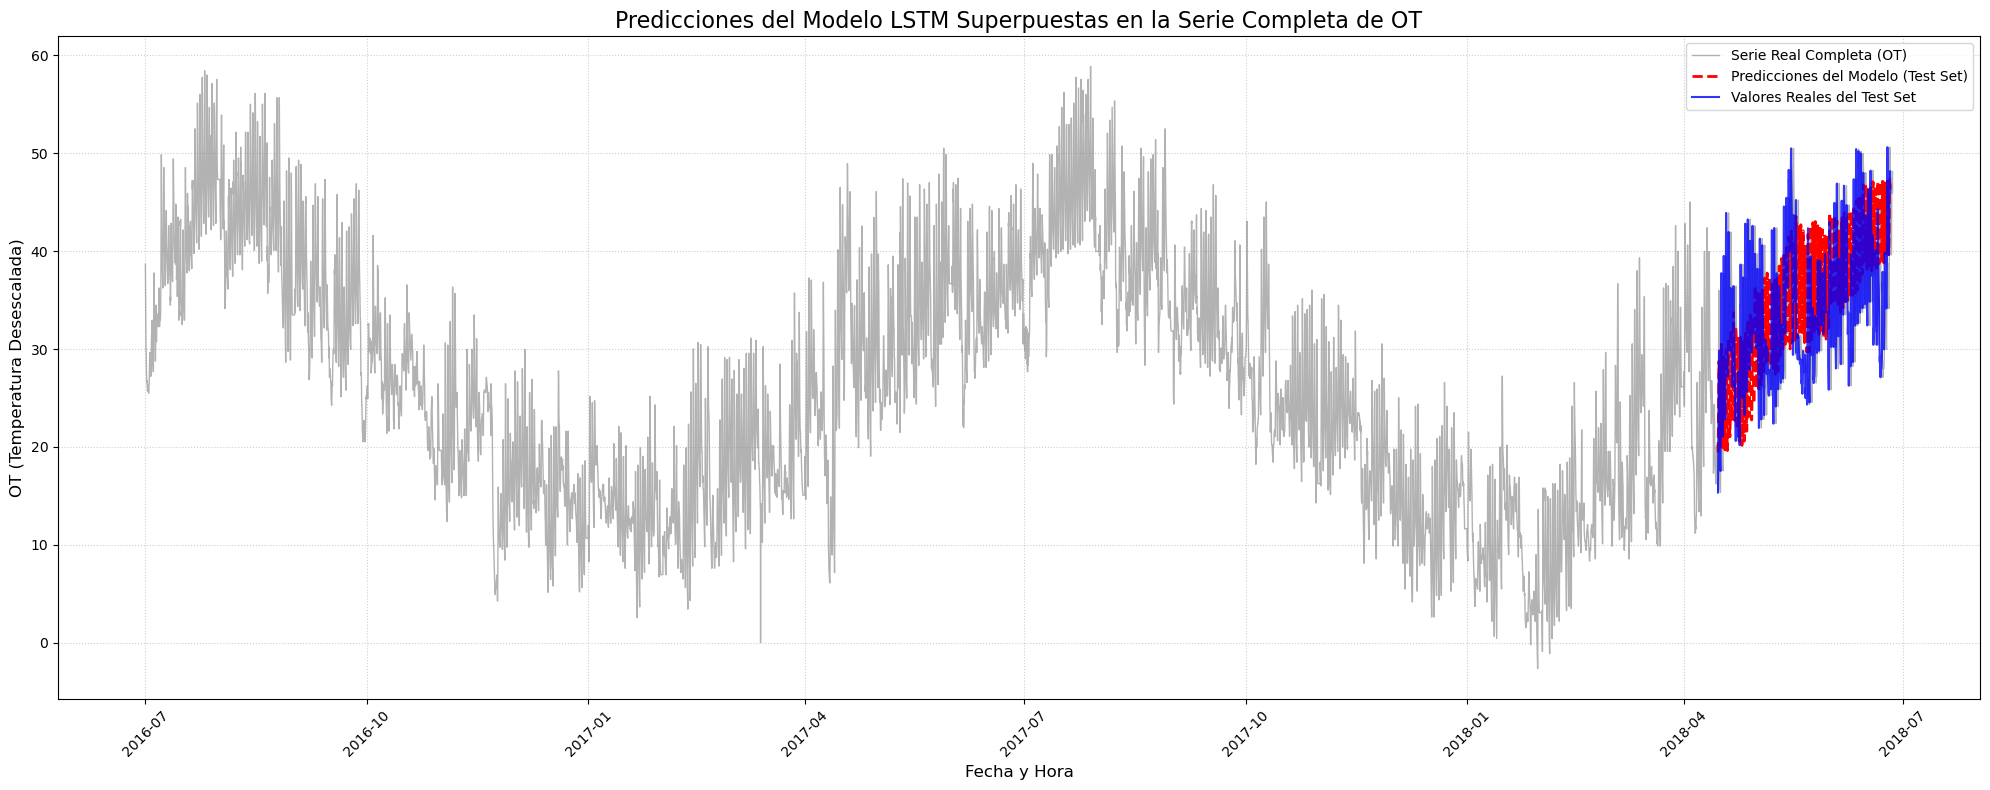

In [158]:
print(SEQUENCE_LENGTH)
plot_full_series_predictions(data, target_col, y_true, y_pred, len(X_train_seq)+len(X_valid_seq), 2 *SEQUENCE_LENGTH)